In [76]:
import shutil, os
import posixpath
import pandas as pd
import swifter
import librosa
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

random_voices_dir = 'data/data_merged'
my_voice_dir = 'data/my_voice'
data_dir = 'data/final_merged_data'

### Functions

In [77]:
def renameFiles(dir):
    i=0
    for file in os.listdir(dir):
        file_split = file.split('.')
        src_path = posixpath.join(dir, file)
        dst_path = posixpath.join(dir, f'kamil-{i}.{file_split[1]}')
        os.rename(src_path, dst_path)
        i+=1

def merge_my_voice_with_others():
    files = os.listdir(random_voices_dir)
    files = [file for file in files if file.split('.')[1]=='flac']
    random.shuffle(files)
    for i in range(51):
        src = posixpath.join(random_voices_dir, files[i])
        dst = posixpath.join(data_dir, files[i])
        shutil.copyfile(src, dst)

    for file in os.listdir(my_voice_dir):
        src = posixpath.join(my_voice_dir, file)
        dst = posixpath.join(data_dir, file)
        shutil.copyfile(src, dst)

def extract_features(files):
    file_name = os.path.join(posixpath.abspath(data_dir)+'/'+str(files.file))
    print(file_name)
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))
    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)

    return mfccs, chroma, mel, contrast, tonnetz

In [79]:
# renameFiles(my_voice_dir)
merge_my_voice_with_others()

filenames = os.listdir(data_dir)
df = pd.DataFrame(filenames)
df = df.rename(columns={0:'file'})
df['speaker'] = df['file'].apply(lambda x: 'kamil' if  x.split('-')[0]=='kamil' else 'random_person')
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,file,speaker
0,5694-64025-0021.flac,random_person
1,kamil-37.flac,kamil
2,kamil-4.flac,kamil
3,kamil-27.flac,kamil
4,kamil-32.flac,kamil
5,1462-170142-0011.flac,random_person
6,3536-8226-0019.flac,random_person
7,kamil-3.flac,kamil
8,3853-163249-0032.flac,random_person
9,kamil-38.flac,kamil


In [ ]:
df.value_counts(['speaker'])

speaker      
kamil            51
random_person    51
dtype: int64

In [82]:
train_features = df.apply(extract_features, axis=1)
features_train = []
for i in range(0, len(train_features)):
    features_train.append(np.concatenate((
        train_features[i][0],
        train_features[i][1], 
        train_features[i][2], 
        train_features[i][3],
        train_features[i][4]), axis=0))

c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/5694-64025-0021.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-37.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-4.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-27.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-32.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/1462-170142-0011.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/3536-8226-0019.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-3.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/3853-163249-0032.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final

F:\Anaconda\envs\tf_gpu3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=746
  n_fft, y.shape[-1]


c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/2428-83699-0031.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-0.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-45.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-49.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/1919-142785-0049.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-28.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-47.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-7.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/777-126732-0079.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged

F:\Anaconda\envs\tf_gpu3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=683
  n_fft, y.shape[-1]


c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/1993-147964-0001.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-22.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/5694-64038-0001.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-50.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-34.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/6313-66129-0019.flac


F:\Anaconda\envs\tf_gpu3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=848
  n_fft, y.shape[-1]


c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/174-50561-0002.flac


F:\Anaconda\envs\tf_gpu3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=740
  n_fft, y.shape[-1]


c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/1919-142785-0033.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/6295-244435-0006.flac


F:\Anaconda\envs\tf_gpu3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=979
  n_fft, y.shape[-1]


c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-12.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/3752-4944-0057.flac


F:\Anaconda\envs\tf_gpu3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=874
  n_fft, y.shape[-1]


c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-18.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/3752-4944-0059.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-48.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/8842-302196-0007.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/5694-64038-0017.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-1.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-39.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/3081-166546-0001.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/1673-143397-0002.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/d

F:\Anaconda\envs\tf_gpu3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=736
  n_fft, y.shape[-1]


c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-2.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/652-130737-0003.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-11.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-29.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/2803-154328-0013.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/8297-275156-0002.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/6241-66616-0018.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/652-130726-0032.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/174-84280-0006.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classifica

F:\Anaconda\envs\tf_gpu3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=808
  n_fft, y.shape[-1]


c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/3000-15664-0043.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-21.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-6.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-19.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/1673-143396-0000.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/1272-141231-0014.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-16.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-30.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/5895-34615-0002.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/fin

F:\Anaconda\envs\tf_gpu3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=870
  n_fft, y.shape[-1]


c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-35.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/5895-34629-0020.flac


F:\Anaconda\envs\tf_gpu3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=777
  n_fft, y.shape[-1]


c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/652-130726-0018.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-10.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-14.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/5895-34629-0016.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/kamil-8.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/5536-43359-0011.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/652-130726-0013.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/6295-64301-0007.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classification/data/final_merged_data/8297-275156-0008.flac
c:\Users\The God of Cringe\Desktop\Python\Voice Classifica

### Split and transform data

In [90]:
X_train, X_test, y_train, y_test = train_test_split(features_train, df['speaker'], test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, shuffle=False) # 0.25 x 0.8 = 0.2

test_df = pd.DataFrame({'file':df['file'].iloc[int(len(df)*0.8):], 'speaker': y_test}).reset_index(drop=True)

lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_val = to_categorical(lb.fit_transform(y_val))

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

### Training

Train on 64 samples, validate on 17 samples
Epoch 1/100
64/64 [==============================] - 1s 8ms/sample - loss: 0.8325 - accuracy: 0.4688 - val_loss: 0.4724 - val_accuracy: 0.9412
Epoch 2/100
64/64 [==============================] - 0s 125us/sample - loss: 0.6745 - accuracy: 0.6094 - val_loss: 0.3291 - val_accuracy: 0.9412
Epoch 3/100
64/64 [==============================] - 0s 172us/sample - loss: 0.3156 - accuracy: 0.9844 - val_loss: 0.2357 - val_accuracy: 0.9412
Epoch 4/100
64/64 [==============================] - 0s 125us/sample - loss: 0.2281 - accuracy: 1.0000 - val_loss: 0.1730 - val_accuracy: 0.9412
Epoch 5/100
64/64 [==============================] - 0s 156us/sample - loss: 0.2365 - accuracy: 0.9219 - val_loss: 0.1306 - val_accuracy: 0.9412
Epoch 6/100
64/64 [==============================] - 0s 156us/sample - loss: 0.1608 - accuracy: 0.9844 - val_loss: 0.1015 - val_accuracy: 0.9412
Epoch 7/100
64/64 [==============================] - 0s 141us/sample - loss: 0.0944 - ac

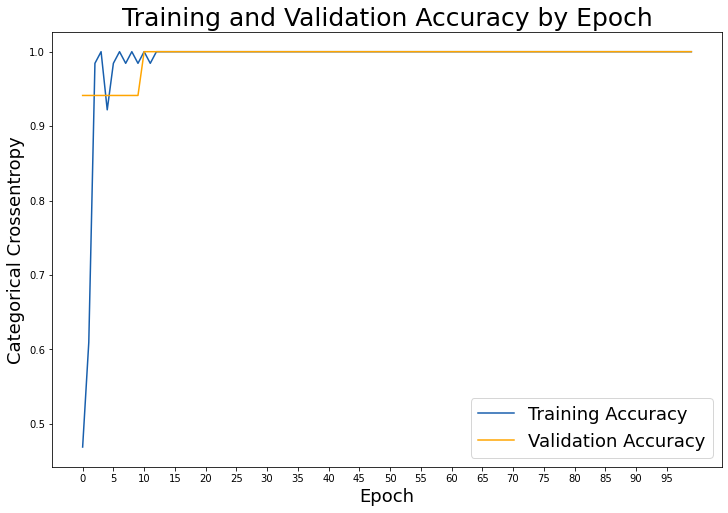

In [91]:
# Build a simple dense model with early stopping and softmax for categorical classification, remember we have 2 classes
model = Sequential()
model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

history = model.fit(X_train, y_train, batch_size=256, epochs=100, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
# Set figure size.
plt.figure(figsize=(12, 8))
# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))
plt.legend(fontsize = 18);

In [92]:
# We get our predictions from the test data
predictions = model.predict_classes(X_test)
# We transform back our predictions to the speakers ids
predictions = lb.inverse_transform(predictions)
# Finally, we can add those predictions to our original dataframe
test_df['predictions'] = predictions

test_df.head()

,file,speaker,predictions
0,kamil-25.flac,kamil,kamil
1,3081-166546-0027.flac,random_person,random_person
2,251-137823-0016.flac,random_person,random_person
3,5536-43359-0017.flac,random_person,random_person
4,kamil-31.flac,kamil,kamil
